# Вебинар 6. Двухуровневые модели рекомендаций


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [46]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [47]:
n_items_before = data_train_lvl_1['item_id'].nunique()


In [49]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, n_popular=5000)


/home/pavel/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/pavel/_GeekBrains/rec_system/src/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / np.maximum(data['quantity'], 1)


In [50]:

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 2455


In [51]:
recommender = MainRecommender(data_train_lvl_1)

In [52]:
recommender.get_als_recommendations(2375, N=5)

[9836106, 1046545, 933067, 999999, 865456]

In [53]:
recommender.get_own_recommendations(2375, N=5)

[907099, 1085983, 999104, 1027642, 9527494]

In [54]:
recommender.get_similar_items_recommendation(2375, N=5)

[999270, 824758, 1103105, 9527160, 896613]

In [55]:
recommender.get_similar_users_recommendation(2375, N=5)

[947326, 1093413, 5568249, 885697, 1098435]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [56]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [57]:
# выбросим холодных юзеров, которых не было на тесте, но появились на трейне.
cold_users = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(cold_users)]

In [58]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], 50), axis=1).mean()

0.06472850685429161

In [59]:
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual'], 50), axis=1).mean()

0.03374567093845079

In [63]:
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean()

0.003957720380489858

Товары, из уже купленных пользователем показали лучший результат. Проверим на них, как изменяется recall  в зависимости от k.

In [60]:
n = [i for i in range(10,501, 20)]
rec_list = []

for i in n:
    result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=i))
    rec_list.append(result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], i), axis=1).mean())

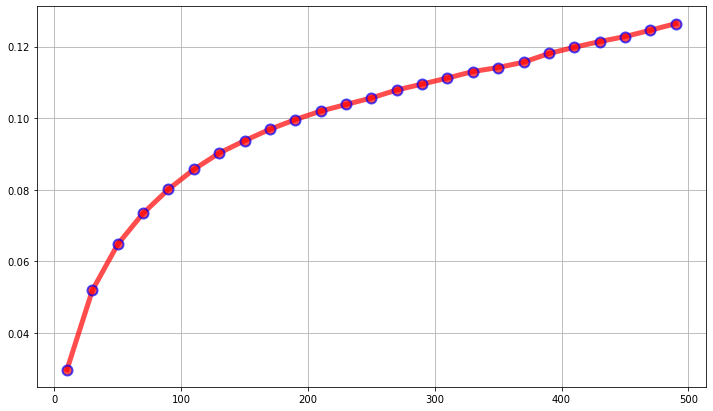

In [61]:
plt.figure(figsize=(12, 7))
plt.plot(n, rec_list, 'o-r', alpha=0.7, label="1/log2(i)", lw=5, mec='b', mew=2, ms=10)

plt.grid(True);

При увеличении k recall@k ожидаемо растет. При большем количестве попыток, мы угадываем все больше реальных покупок. Однако, рост не линеен, и, судя по графику, 50 - явно не оптимальное значение. Recall продолжает быстро расти, и выбрать k стоит, возможно, в районе 150-200 товаров. Впрочем, это гиперпараметр и точное значение зависит от работы модели второго уровня.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [18]:
new_item_features = item_features.merge(data, on='item_id', how='left')

    
price = new_item_features.groupby('item_id')['sales_value'].sum() / new_item_features.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'price']
price['price'].fillna(0, inplace= True)

# item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
# item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
# item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()
# item_features = item_features.merge(item_qnt, on='item_id')
# item_qnt 
# item_features
price

,item_id,price
0,25671,3.49
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,0.99
...,...,...
92348,18293142,0.00
92349,18293439,0.00
92350,18293696,0.00
92351,18294080,0.00


In [19]:
new_item_features.head(10)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,user_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1228.0,2.904662e+10,157.0,1.0,3.49,3313.0,0.00,2213.0,23.0,0.0,0.0
1,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,358.0,3.070761e+10,247.0,1.0,3.49,3266.0,0.00,1211.0,36.0,0.0,0.0
2,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,325.0,3.304671e+10,410.0,4.0,13.96,3191.0,0.00,1139.0,59.0,0.0,0.0
3,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1675.0,3.076027e+10,250.0,1.0,0.99,3235.0,0.00,936.0,36.0,0.0,0.0
4,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1032.0,3.378385e+10,458.0,1.0,1.59,33904.0,0.00,2034.0,66.0,0.0,0.0
5,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1420.0,3.059125e+10,238.0,1.0,1.54,3297.0,0.00,1342.0,35.0,0.0,0.0
6,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,486.0,3.063677e+10,242.0,2.0,1.98,3217.0,-0.52,1411.0,35.0,0.0,0.0
7,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ,1675.0,2.880275e+10,142.0,1.0,2.29,3235.0,0.00,1713.0,21.0,0.0,0.0
8,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ,1409.0,2.851726e+10,121.0,2.0,1.82,3313.0,0.00,909.0,18.0,0.0,0.0
9,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ,1409.0,3.019261e+10,224.0,1.0,0.97,3313.0,0.00,1635.0,33.0,0.0,0.0


In [20]:
def new_user_features(data, user_features):
    '''
    Добавляет среднюю корзину и средний чек за неделю.
    '''
    
    new_user_features = user_features.merge(data, on='user_id', how='left')

    
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)
    average_basket = basket.merge(baskets_qnt)
    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()
    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)
    user_features = user_features.merge(average_basket)
    
    

    return user_features

In [21]:
def new_item_features(data, item_features):
    
    '''
    Считает цену, количество продаж и продаваемость за неделю.
    '''
    
    new_item_features = item_features.merge(data, on='item_id', how='left')
    
   
    price = new_item_features.groupby('item_id')['sales_value'].sum() / new_item_features.groupby('item_id')['quantity'].sum()
    price = price.groupby('item_id').mean().reset_index()
    price.columns = ['item_id', 'price']
    price['price'].fillna(0, inplace= True)
    
    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
    item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()
    
    item_features = item_features.merge(item_qnt, on='item_id')
    item_features = item_features.merge(price, on='item_id')
    item_features = item_features[item_features['quantity_of_sales']>0]
    
    return item_features

In [22]:
item_features = new_item_features(data_train_lvl_2, item_features)

In [23]:
user_features = new_user_features(data_train_lvl_2, user_features)

In [24]:
def train_test_preprocessing(data):    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    train_users = data_train_lvl_1['user_id'].unique()
    train_users.shape

    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2_ = users_lvl_2.copy()
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    
    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)

    targets_lvl_2['target'] = 1  

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X = targets_lvl_2.drop('target', axis=1)
    y = targets_lvl_2[['target']]
    
    return X, y

In [25]:
X_train, y_train = train_test_preprocessing(data_train_lvl_2)

In [26]:
cat_feats = X_train.columns[2:].tolist()

In [27]:
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test, y_test = train_test_preprocessing(data_val_lvl_2)
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [28]:
lgb = LGBMClassifier(objective='binary', max_depth=10, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

test_preds_proba = lgb.predict_proba(X_test)[:, 1]

/home/pavel/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/pavel/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [29]:
test_preds_proba[:10]

array([0.000691  , 0.0164664 , 0.0167403 , 0.10445331, 0.000691  ,
       0.000691  , 0.000691  , 0.00569917, 0.000691  , 0.09597097])

In [30]:
def get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2):
    X_test['predict_proba'] = test_preds_proba

    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

    result = X_test.groupby('user_id').head(5)

    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})

    recomendations = pd.DataFrame(recomendations)

    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']

    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [31]:
result_lvl_2 = get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2)

In [32]:
result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.10710436060754477

Пока одноуровневая модель LightgGBM показала значительно лучшие результаты. Увы, времени на тесты и настройку двухуровневой модели попросту не хватило, и выводы делать рано. Но с другой стороны, и LightgGBM тестировалась "по дефолту", без отбора и генерации признаков, так что у нее еще есть потенциал.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 